<a href="https://colab.research.google.com/github/gilvandroneto/GEDL1_2019/blob/master/Lesson_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Lição 1 fast.ai adaptado para o Google Colab

In [0]:
#atualiza as libs necessárias para o funcionamento do fast ai

!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
#Monta um drive persistente dentro do google drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Definição do diretório de trabalho
folder = 'lesson1'
path = Path(base_dir + 'data/bears')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

# fast.ai lesson 1 - training on Notebook Instance and export to torch.jit model

## Overview
This notebook shows how to use the SageMaker Python SDK to train your fast.ai model on a SageMaker notebook instance then export it as a torch.jit model to be used for inference on AWS Lambda.

## Set up the environment

You will need a Jupyter notebook with the `boto3` and `fastai` libraries installed. You can do this with the command `pip install boto3 fastai`

This notebook was created and tested on a single ml.p3.2xlarge notebook instance. 


## Train your model

We are going to train a fast.ai model as per [Lesson 1 of the fast.ai MOOC course](https://course.fast.ai/videos/?lesson=1) locally on the SageMaker Notebook instance. We will then save the model weights and upload them to S3.



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
import io
import tarfile

import PIL

import boto3

from fastai.vision import *

In [0]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path_anno = path/'annotations'
path_img = path/'images'
fnames = get_image_files(path_img)
np.random.seed(2)
pat = re.compile(r'/([^/]+)_\d+.jpg$')

In [0]:
bs=64
img_size=299

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=img_size, bs=bs//2).normalize(imagenet_stats)

In [0]:
#learn = create_cnn(data, models.resnet50, metrics=error_rate)

#alterado de create_cnn para cnn_learner

learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 88156070.88it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


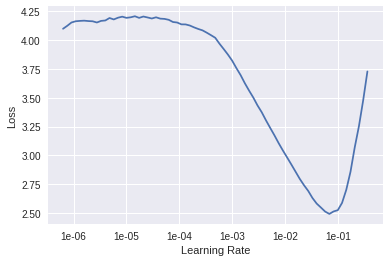

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
## Reduzido numero de ciclos para 1

#learn.fit_one_cycle(8)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.307188,0.181118,0.061570,03:30


In [0]:
# Reduzido numero de ciclos

#learn.unfreeze()
#learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.221397,0.155280,0.048038,04:38


## Export model and upload to S3

Now that we have trained our model we need to export it, create a tarball of the artefacts and upload to S3.


First we need to export the class names from the data object into a text file.

In [0]:
save_texts(path_img/'models/classes.txt', data.classes)

Now we need to export the model in the [PyTorch TorchScript format](https://pytorch.org/docs/stable/jit.html) so we can load into an AWS Lambda function.

In [0]:
trace_input = torch.ones(1,3,img_size,img_size).cuda()
jit_model = torch.jit.trace(learn.model.float(), trace_input)
model_file='resnet50_jit.pth'
output_path = str(path_img/f'models/{model_file}')
torch.jit.save(jit_model, output_path)

Next step is to create a tarfile of the exported classes file and model weights.

In [0]:
#Caminho alterado para o diretório montado do Google Drive

#tar_file=path_img/'models/model.tar.gz'
tar_file=dest/'model.tar.gz'
classes_file='classes.txt'

In [0]:
#Nesta operação de escrita, o modelo já é salvo no google drive
with tarfile.open(tar_file, 'w:gz') as f:
    f.add(path_img/f'models/{model_file}', arcname=model_file)
    f.add(path_img/f'models/{classes_file}', arcname=classes_file)

Now we need to upload the model tarball to S3.

In [0]:
#s3 = boto3.resource('s3')
#s3.meta.client.upload_file(str(tar_file), 'REPLACE_WITH_YOUR_BUCKET_NAME', 'fastai-models/lesson1/model.tar.gz')

In [0]:
# Método alternativo de upload para o drive

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# # Create & upload a file.
# uploaded = drive.CreateFile({'title': 'example.tar'})
# uploaded.SetContentFile(str(tar_file))
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1bqkVKer_hyKs47gu80PF79T6nLQbclKh
